# Задание

Проанализировать данные из датасета, провести их очистку (вплоть до удаления записей) и построить классификатор, что будет наилучшим образом (и равномерно) предсказывать классы.
* Финальный macro F-score не должен быть ниже 0.55.
* При удалении элементов из датасета, в нём должно остаться не менее 20 000 сэмплов.

# Настройки/Импорты

Версии важных модулей:
* pandas==2.1.1
* numpy==1.26.2
* tensorflow==2.15.0 (no GPU)
* tensorflow-text==2.15.0
* keras==2.15.0
* keras-nlp==0.12.1
* matplotlib==3.6.2
* navec==0.10.0

In [1]:
# !pip install pandarallel==1.6.5
# !pip install pymorphy3==1.2.0
# !pip install navec==0.10.0
# !pip install tensorflow==2.15.0
# !pip install tensorflow-text==2.15.0
# !pip install keras==2.15.0
# !pip install keras_nlp==0.12.1

# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

In [2]:
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import psutil # для просмотра числа потоков на cpu
from pandarallel import pandarallel # для параллельного запуска кода на cpu
from typing import Iterable # для параметра функции, по которому можно итерироваться
import pickle # для сохранения файлов

from tensorflow.data import Dataset # для создания датасета tensorflow и использования их word_piece токенизатора
from keras_nlp.tokenizers import compute_word_piece_vocabulary, WordPieceTokenizer # keras для задачи NLP
from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # для токенизации строк
from pymorphy3 import MorphAnalyzer # для работы со словами (лемматизация, часть речи...)
from keras.preprocessing.text import Tokenizer # токенизатор текста (на версии keras 2.15.0 можно не тягать из tensorflow)
from keras.utils import pad_sequences # для приведения векторов токенов к единой размерности
from sklearn.utils import resample # для upsample и downsample данных (выравнивание классов)
from sklearn.model_selection import train_test_split # для разбиения на обучающую и тестовую выборку
from navec import Navec # для русскоязычных эмбеддингов

from keras.layers import Input, Dense, Dropout, Embedding, LSTM # слои для нейронной сети
from keras_nlp.layers import TokenAndPositionEmbedding # слои для нейронной сети
from keras.models import Model # Keras модель (не последовательная)
from keras.callbacks import ModelCheckpoint, EarlyStopping # callback функции
import keras # для работы с моделью

import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt # для построения графиков
from wordcloud import WordCloud # для построения изображения с самыми часто встречаемыми словами (помогает в определении дополнительных стоп-слов)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # для оценки качества предсказаний


Using TensorFlow backend


In [3]:
DATA_DIR = "./data/" # путь до папки с данными
EMBEDDING_DIR = "./embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "./models/" # путь до папки с моделями
DATA_COL = "text" # столбец, отвечающий за входные данные
TARGET_COL = "tag" # столбец, отвечающий за таргеты
RANDOM_STATE = 42 # число для задания случайности
DTYPE = np.float32 # используемый тип

ADD_STOP_WORDS = [",", ".", "...", "?", "!", ":", "-", "(", ")", "``", "''", "Я", "Вы", "это", "И", "А", "Но", "очень", "просто", "нужно"] # дополнительные стоп-слова
MAX_WORDS_TOKENIZER = 20000 # ограничение на число слов в словаре токенизатора (None — без ограничения)
MAX_SEQUENCE_LEN = 100 # оптимальное число токенов в документе (если не достаёт — padding, если перебор — truncation), определялось по гистограмме распределения числа токенов в текстах
EMBEDDING_DIM = 300 # размерность вектора-эмбеддинга слова
SAMPLES_PER_CLASS = 5000 # сколько должно быть сэмплов в каждом классе (None для выравнивания по наиболее представленному классу)
TEST_SIZE = 0.2 # размер тестовой выборки

EPOCHS_PATIENCE = 5 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
EPOCHS = 50 # число эпох обучения
LEARNING_RATE = 0.0001 # learning rate
BATCH_SIZE = 50 # размер батча (число сэмплов, передаваемых в модель одновременно => чем больше значение - тем быстрее обучение, но хуже качество из-за аккумуляции градиентов)

In [4]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False)) # число доступных потоков

Количество доступных потоков:  4


In [5]:
# from google.colab import drive # для Google Drive
# drive.mount('/content/drive') # подключаемся к Google Drive

# # перезаписываем важные переменные
# DATA_DIR = "/content/drive/MyDrive/tmp/data/" # путь до папки с данными
# EMBEDDING_DIR = "/content/drive/MyDrive/tmp/embeddings/" # путь до папки с эмбеддингами
# MODELS_DIR = "/content/drive/MyDrive/tmp/models/" # путь до папки с моделями

# Предобработка датасета

In [6]:
dataset = pd.read_csv(f"{DATA_DIR}Data_Sources.csv", sep=";", encoding="UTF-8") # считывание данных в формате csv, разделённых с помощью символа sep и закодированных в encoding (можно проверить с помощью Notepad++, тип кодировки будет справа снизу)
dataset

,url,date,text,tag,source
0,https://vk.com/club3291025?w=wall-3291025_1020782,2023-04-15 19:39,Всем добрый день! У меня БАР 2 типа. Начала ч...,БАР,ВК
1,https://vk.com/id32362343,2023-04-15 19:46,это на всякий случай?,БАР,ВК
2,https://vk.com/id415411329,2023-04-15 19:44,Попробуйте успокоиться. Сделайте выводы. Приго...,БАР,ВК
3,https://vk.com/id777797099,2023-04-15 19:44,На все вопросы вы ответили сами.,БАР,ВК
4,https://vk.com/id739587393,2023-04-15 19:47,"Всё к лучшему. Если вы так сделали, значит так...",БАР,ВК
...,...,...,...,...,...
66455,https://vk.com/id19312999,2019-04-02 9:03,https://pcixi.ru/forum/88-9302-1 Исцеление люб...,шизофрения,ВК
66456,https://vk.com/id19312999,2019-04-02 10:35,не лечится анамалия развития? То есть если я с...,шизофрения,ВК
66457,https://vk.com/id19312999,2019-04-02 18:31,"благодарю за ответ. Спасибо, я почитаю про шиз...",шизофрения,ВК
66458,https://vk.com/id293789448,2019-04-02 22:17,"в церковь ходили, батюшка лет 20 назад очень п...",шизофрения,ВК


Изначальное распределение лейблов в датасете.

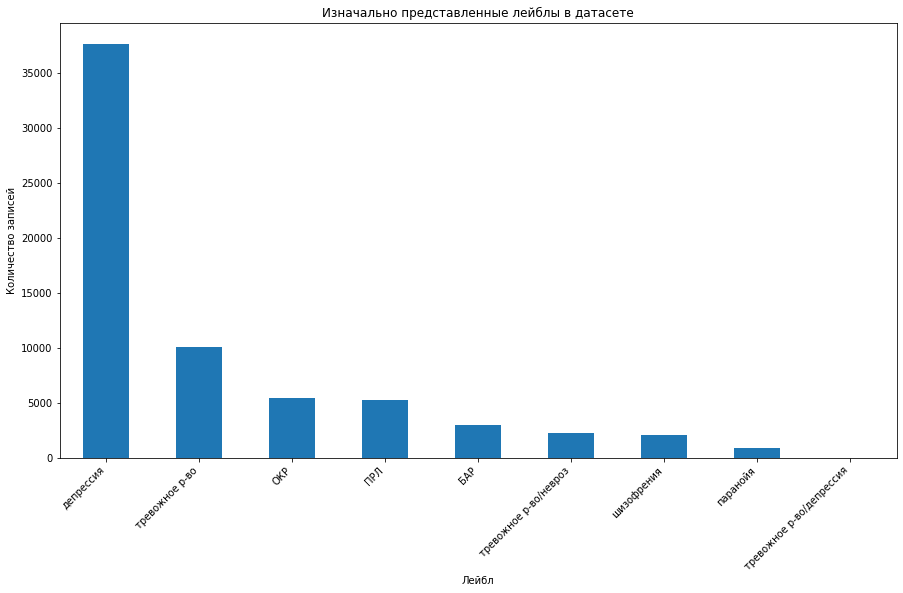

In [7]:
plt.figure(figsize=(15,8)) # задание размера фигуры
dataset[TARGET_COL].value_counts().plot.bar() # построение столбчатой диаграммы по данным
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Изначально представленные лейблы в датасете") # название фигуры
plt.xlabel("Лейбл") # подпись по оси x
plt.ylabel("Количество записей") # подпись по оси y
plt.show() # показ фигуры

## Очистка датасета

### Удаляем или заменяем столбцы, что не несут полезную информацию.

In [8]:
dataset[TARGET_COL].replace("тревожное р-во/депрессия", "тревожное р-во", inplace=True) # заменяем все записи, что были малопредставлены на их аналог или None (для последующего удаления)
dataset[TARGET_COL].replace("тревожное р-во/невроз", "тревожное р-во", inplace=True) # заменяем все записи, что были малопредставлены на их аналог или None (для последующего удаления)
dataset[TARGET_COL].replace("паранойя", None, inplace=True) # заменяем все записи, что были малопредставлены на их аналог или None (для последующего удаления)
dataset.dropna(axis=0, inplace=True) # удаляем строки (axis=0), в которых есть пропущенные значения

dataset.drop(labels=["url", "date", "source"], axis=1, inplace=True) # удаляем ненужные столбцы (labels по axis=1) с перезаписью (inplace=True)

dataset

,text,tag
0,Всем добрый день! У меня БАР 2 типа. Начала ч...,БАР
1,это на всякий случай?,БАР
2,Попробуйте успокоиться. Сделайте выводы. Приго...,БАР
3,На все вопросы вы ответили сами.,БАР
4,"Всё к лучшему. Если вы так сделали, значит так...",БАР
...,...,...
66455,https://pcixi.ru/forum/88-9302-1 Исцеление люб...,шизофрения
66456,не лечится анамалия развития? То есть если я с...,шизофрения
66457,"благодарю за ответ. Спасибо, я почитаю про шиз...",шизофрения
66458,"в церковь ходили, батюшка лет 20 назад очень п...",шизофрения


### Удаляем стоп-слова и мусорные значения.

Считаем распределение токенов по датасету.

In [9]:
tokens_distribution = {} # словарь под распределение токенов по классам

dataset[DATA_COL] = dataset[DATA_COL].apply(lambda text: word_tokenize(text, language="russian")) # разбиваем текст на слова (токены)
for target_value in dataset[TARGET_COL].unique(): # идём по значениям таргетов
    tokens_distribution[target_value] = {} # словарь под слова с рассматриваемым таргетом
    for sequence in dataset[dataset[TARGET_COL] == target_value][DATA_COL]: # идём по записям (строкам в DataFrame, последовательностям токенов) с рассматриваемым таргетом
        for token in sequence: # идём по токенам в последовательности
            if token in tokens_distribution[target_value].keys(): # если токен уже был встречен в классе
                tokens_distribution[target_value][token] += 1
            else: # если токен встречается впервые
                tokens_distribution[target_value][token] = 1
tokens_distribution = pd.DataFrame(tokens_distribution) # собираем DataFrame на основе словаря
tokens_distribution.fillna(0, inplace=True) # пропущенные значения заполняем нулями - токен ни разу не встретился в таких записях

tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,7.0,45.0,9.0,14.0,19.0,3.0
добрый,6.0,129.0,17.0,17.0,42.0,6.0
день,94.0,1538.0,230.0,127.0,713.0,43.0
!,642.0,6089.0,785.0,838.0,1967.0,431.0
У,178.0,2101.0,305.0,302.0,639.0,144.0
...,...,...,...,...,...,...
незанятым,0.0,0.0,0.0,0.0,0.0,1.0
выметенным,0.0,0.0,0.0,0.0,0.0,1.0
убранным,0.0,0.0,0.0,0.0,0.0,1.0
злейших,0.0,0.0,0.0,0.0,0.0,1.0


Оставляем только те токены, что встречаются не слишком редко.

In [10]:
MIN_TOKEN_COUNT = 20 # минимальное число раз, сколько токен должен быть встречен
tokens_distribution = tokens_distribution[tokens_distribution.sum(axis=1) > MIN_TOKEN_COUNT] # оставляем только те токены, что встречались не менее MIN_TOKEN_COUNT раз
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,7.0,45.0,9.0,14.0,19.0,3.0
добрый,6.0,129.0,17.0,17.0,42.0,6.0
день,94.0,1538.0,230.0,127.0,713.0,43.0
!,642.0,6089.0,785.0,838.0,1967.0,431.0
У,178.0,2101.0,305.0,302.0,639.0,144.0
...,...,...,...,...,...,...
тонометр,0.0,0.0,0.0,0.0,25.0,0.0
Соня,0.0,0.0,0.0,0.0,31.0,0.0
тонометра,0.0,0.0,0.0,0.0,38.0,0.0
МП,0.0,0.0,0.0,0.0,29.0,0.0


Переходим к распределению токенов по классам.

In [11]:
target_count = dataset[TARGET_COL].value_counts() # число записей с определённым таргетом
for target_value in tokens_distribution.columns: # идём по значениям таргетов
    tokens_distribution[target_value] = tokens_distribution[target_value] / target_count[target_value] # считаем, насколько часто встречается токен среди записей по таргету

tokens_distribution

C:\Users\User\Documents\TEMP\ipykernel_19460\2366456831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokens_distribution[target_value] = tokens_distribution[target_value] / target_count[target_value] # считаем, насколько часто встречается токен среди записей по таргету


,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.002505,0.001201,0.001745,0.002683,0.001546,0.001460
добрый,0.002147,0.003442,0.003296,0.003257,0.003418,0.002920
день,0.033644,0.041041,0.044591,0.024334,0.058029,0.020925
!,0.229778,0.162482,0.152191,0.160567,0.160088,0.209732
У,0.063708,0.056064,0.059131,0.057865,0.052006,0.070073
...,...,...,...,...,...,...
тонометр,0.000000,0.000000,0.000000,0.000000,0.002035,0.000000
Соня,0.000000,0.000000,0.000000,0.000000,0.002523,0.000000
тонометра,0.000000,0.000000,0.000000,0.000000,0.003093,0.000000
МП,0.000000,0.000000,0.000000,0.000000,0.002360,0.000000


Стоп-слова.

In [12]:
# stop_words = [] # список стоп-слов
stop_words = stopwords.words('russian') # список стоп-слов для языка
for add_stop in ADD_STOP_WORDS: # идём по дополнительным стоп-словам
    stop_words.append(add_stop) # добавляем стоп-слово

tokens_distribution.loc[[token for token in stop_words if token in tokens_distribution.index]] # распределение стоп-слов в датасете

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
и,1.186113,1.359706,1.526367,1.260970,1.554651,1.340633
в,0.852899,0.959733,1.044397,0.889634,1.124440,0.918248
во,0.024696,0.032128,0.039550,0.029891,0.035647,0.023844
не,0.957767,1.104043,1.283637,1.063039,1.138602,1.217032
что,0.631711,0.795464,0.990694,0.779843,0.844795,0.674453
...,...,...,...,...,...,...
А,0.130995,0.137852,0.174486,0.151370,0.170261,0.171776
Но,0.094488,0.097612,0.153742,0.125695,0.118825,0.102676
очень,0.100573,0.117759,0.121753,0.141406,0.132986,0.103650
просто,0.061918,0.099320,0.121753,0.096762,0.097990,0.092457


In [13]:
tokens_distribution = tokens_distribution.loc[[token for token in tokens_distribution.index if token not in stop_words]] # удаляем стоп-слова
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.002505,0.001201,0.001745,0.002683,0.001546,0.001460
добрый,0.002147,0.003442,0.003296,0.003257,0.003418,0.002920
день,0.033644,0.041041,0.044591,0.024334,0.058029,0.020925
У,0.063708,0.056064,0.059131,0.057865,0.052006,0.070073
БАР,0.077309,0.001094,0.000000,0.002683,0.000326,0.000487
...,...,...,...,...,...,...
тонометр,0.000000,0.000000,0.000000,0.000000,0.002035,0.000000
Соня,0.000000,0.000000,0.000000,0.000000,0.002523,0.000000
тонометра,0.000000,0.000000,0.000000,0.000000,0.003093,0.000000
МП,0.000000,0.000000,0.000000,0.000000,0.002360,0.000000


Удаляем слова, что даже в классах встречаются слишком редко.

In [14]:
MIN_TOKEN_DISTRIBUTION = 0.001 # минимальное частота использования токена
tokens_distribution = tokens_distribution[tokens_distribution.max(axis=1) > MIN_TOKEN_DISTRIBUTION] # оставляем только те строки, у которых частота использования слова по классу не менее MIN_TOKEN_DISTRIBUTION
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.002505,0.001201,0.001745,0.002683,0.001546,0.001460
добрый,0.002147,0.003442,0.003296,0.003257,0.003418,0.002920
день,0.033644,0.041041,0.044591,0.024334,0.058029,0.020925
У,0.063708,0.056064,0.059131,0.057865,0.052006,0.070073
БАР,0.077309,0.001094,0.000000,0.002683,0.000326,0.000487
...,...,...,...,...,...,...
тонометр,0.000000,0.000000,0.000000,0.000000,0.002035,0.000000
Соня,0.000000,0.000000,0.000000,0.000000,0.002523,0.000000
тонометра,0.000000,0.000000,0.000000,0.000000,0.003093,0.000000
МП,0.000000,0.000000,0.000000,0.000000,0.002360,0.000000


Считаем важные слова для всех классов.

In [15]:
important_tokens = [] # список токенов, что вносят вклад в определение классов

# important_tokens = list(tokens_distribution.index)
for index, row in tokens_distribution.iterrows():
    if row.max() - row.mean() > 0.015: # если токен несёт разницу для классов
        important_tokens.append(index) # запоминаем его как важное слово

print(f"Число значимых токенов: {len(important_tokens)}.")

Число значимых токенов: 72.


In [16]:
important_tokens

['день',
 'БАР',
 'отношения',
 'работать',
 'Если',
 'Вас',
 'человека',
 'что-то',
 'лечение',
 'её',
 'дети',
 'время',
 'отношениях',
 'тему',
 'тревога',
 'именно',
 'депрессия',
 '..',
 'помочь',
 'которые',
 'Ну',
 'диагноз',
 'ещё',
 'жизни',
 'мании',
 'Вам',
 'жить',
 '«',
 '»',
 'хотите',
 'писал',
 'депрессии',
 'людей',
 'мысли',
 'деньги',
 'эмоции',
 'помощь',
 'личности',
 'психиатру',
 'мысль',
 'страх',
 'терапии',
 'работе',
 'детей',
 'мама',
 '--',
 'тревогу',
 'голове',
 'матери',
 'ОКР.',
 'ОКР',
 'мать',
 'получается',
 '%',
 'мыслей',
 'маме',
 'шизофрении',
 'шизофрения',
 'ПА',
 'тревоги',
 'давление',
 'Ольга',
 'ПРЛ',
 'шизофренией',
 'прл',
 'ритуалы',
 'Алина',
 '|',
 'Ri',
 'Star',
 'Яна',
 'D0']

In [17]:
tokens_distribution.loc[important_tokens].idxmax(axis=1).value_counts()

шизофрения        22
тревожное р-во    14
ОКР               14
ПРЛ               13
депрессия          5
БАР                4
Name: count, dtype: int64

Считаем важные слова для каждого класса в частности. Для этого переводим частоту встречи слова в классе во вклад слова в класс с помощью Softmax.

In [18]:
for index, row in tokens_distribution.iterrows(): # идём по токенам
    new_row = np.exp(row)/np.sum(np.exp(row)) # считаем новое значение в строке с помощью softmax (вклад слова в таргет)
    tokens_distribution.loc[index] = np.exp(row)/np.sum(np.exp(row)) # обновляем значение
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.166775,0.166557,0.166648,0.166804,0.166615,0.166601
добрый,0.166511,0.166727,0.166703,0.166696,0.166723,0.166640
день,0.166080,0.167313,0.167908,0.164541,0.170179,0.163981
У,0.167315,0.166041,0.166551,0.166340,0.165369,0.168384
БАР,0.177548,0.164519,0.164339,0.164781,0.164393,0.164419
...,...,...,...,...,...,...
тонометр,0.166610,0.166610,0.166610,0.166610,0.166949,0.166610
Соня,0.166597,0.166597,0.166597,0.166597,0.167017,0.166597
тонометра,0.166581,0.166581,0.166581,0.166581,0.167097,0.166581
МП,0.166601,0.166601,0.166601,0.166601,0.166995,0.166601


In [19]:
class_tokens = {} # словарь с важными для классов токенами
for label in tokens_distribution.columns: # идём по классам
    class_tokens[label] = list(tokens_distribution.loc[important_tokens][label].nlargest(15).index) # берём топ-10 слов, вносящих вклад в класс label среди всех важных слов important_tokens
    print(f"Для класса {label} важными токенами являются {class_tokens[label]}.")

Для класса БАР важными токенами являются ['БАР', 'лечение', 'депрессии', 'мании', 'работать', 'диагноз', 'депрессия', '--', 'терапии', 'Вас', 'тему', 'мама', 'психиатру', 'деньги', 'помочь'].
Для класса депрессия важными токенами являются ['депрессии', '»', '«', 'депрессия', 'жизни', 'время', 'которые', 'эмоции', 'день', 'мыслей', 'отношения', 'ещё', 'хотите', 'жить', 'отношениях'].
Для класса ОКР важными токенами являются ['мысли', 'что-то', 'ОКР', 'страх', '..', 'мысль', 'именно', 'Ну', 'ОКР.', 'мыслей', 'которые', 'получается', 'ритуалы', 'тему', 'время'].
Для класса ПРЛ важными токенами являются ['ПРЛ', '|', 'писал', 'прл', 'отношения', 'личности', 'Ольга', 'Ri', 'Star', 'Алина', 'отношениях', 'эмоции', 'терапии', 'диагноз', 'матери'].
Для класса тревожное р-во важными токенами являются ['--', 'тревога', 'тревоги', 'ПА', 'Вас', 'давление', 'мысли', 'день', 'ещё', 'страх', 'Вам', 'тревогу', 'Яна', 'голове', 'работе'].
Для класса шизофрения важными токенами являются ['%', 'детей', 'ш

V1) Доочистим датасет, оставив в нём лишь хорошие данные для классов.

In [20]:
for label in tokens_distribution.columns: # идём по таргетам
    for index, row in dataset[dataset[TARGET_COL] == label].iterrows(): # идём по сэмплам
        if not any(token in row[DATA_COL] for token in class_tokens[label]): # если в сэмпле класса label нет слов, важных для класса label
            dataset[DATA_COL][index] = None # делаем значение в ячейке NaN

dataset.dropna(axis=0, inplace=True) # удаляем строки (axis=0), в которых есть пропущенные значения
dataset.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)
dataset

,text,tag
0,"[Всем, добрый, день, !, У, меня, БАР, 2, типа,...",БАР
1,"[вы, серьезно, ?, Алкоголизм, это, к, лучшему,...",БАР
2,"[Лучше, сменить, фармакотерапию, и, продолжить...",БАР
3,"[Приветствую, вас, ., Это, очень, трудная, сит...",БАР
4,"[это, вы, сейчас, человеку, с, БАР, такой, бре...",БАР
...,...,...
20889,"[если, голоса, слышит, ,, есть, бред, ,, то, э...",шизофрения
20890,"[шизофрения, не, всегда, становится, все, хуже...",шизофрения
20891,"[благодарю, за, ответ., Спасибо, ,, я, почитаю...",шизофрения
20892,"[в, церковь, ходили, ,, батюшка, лет, 20, наза...",шизофрения


V2) Дополнительно преобразуем датасет.

In [21]:
pandarallel.initialize(progress_bar=True) # запуск в параллельном режиме (с отображением прогресса выполнения)

def clear_data(df: pd.DataFrame, stop_words: Iterable=[], important_tokens: Iterable=[], min_tokens: np.int32=15) -> pd.DataFrame:
    """
    Универсальная параллельная функция для очистки датасета, перезапишет переданный объект.\n
    Parameters:
        * df: рассматриваемый датасет
        * columns: столбцы в датасете, что будут очищаться
        * stop_words: какие стоп-слова использовать
        * important_tokens: не стоп-слова, если переданы — то оставляем только их
        * min_tokens: минимальное число токенов в записи, чтобы её не удалить из датасета\n
    Returns:
        * pd.DataFrame: датасет с очищенными столбцами columns
    """
    # импортируем, так как потоки их перестанут видеть
    from nltk.tokenize import word_tokenize # для токенизации строк
    from pymorphy3 import MorphAnalyzer # для работы со словами (лемматизация, часть речи...)

    morph = MorphAnalyzer() # объект для лемматизации слов
    global MAX_SEQUENCE_LEN # для изменения оптимальной длины последовательности


    df[TARGET_COL] = df[TARGET_COL].parallel_apply(lambda text: text.upper()) # делаем так, чтобы таргеты шли в верхнем регистре (не совпали с такими же словами в данных, что будут идти в нижнем регистре)
    # df[DATA_COL] = df[DATA_COL].parallel_apply(lambda text: text.lower()) # приводим к нижнему регистру
    # df[DATA_COL] = df[DATA_COL].parallel_apply(lambda text: word_tokenize(text, language="russian")) # разбиваем текст на слова (токены)
    df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: [morph.parse(word)[0].normal_form for word in sequence]) # приводим слова к нормальной форме (если она у них есть, иначе они остаются без изменения)
    if len(important_tokens) > 0: # если передали важные слова
        # df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: [word for word in sequence if word in important_tokens]) # оставляем только важные слова
        df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: sequence if any(token in sequence for token in important_tokens) else []) # если встречается хотя бы одно важное слово — оставляем сэпмл, иначе - зануляем
    else: # иначе — удаляем стоп-слова
        df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: [word for word in sequence if word not in stop_words]) # удаляем стоп-слова
    df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: sequence if len(sequence) >= min_tokens else None) # удаляем записи, если в них встречено менее min_tokens токенов
    df.dropna(axis=0, inplace=True) # удаляем строки (axis=0), в которых есть пропущенные значения

    # определяем оптимальную длину последовательности
    lengths = [] # список под длины документов в токенах
    for sequence in dataset[DATA_COL]: # идём по последовательностям токенов
        lengths.append(len(sequence)) # добавляем число токенов в документе в список
    MAX_SEQUENCE_LEN = int(np.quantile(lengths, q=0.95)) # считаем квантиль уровня q
    print(f"Максимальная длина документа в токенах: {max(lengths)}.")
    print(f"Квантиль длины документа уровня 0.95: {MAX_SEQUENCE_LEN}.")

    df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: " ".join(sequence)) # собираем последовательность слов обратно в строку, но теперь даже служебные символы разделены пробелами
    df.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)

    return df

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [22]:
# dataset = clear_data(df=dataset.copy(), important_tokens=important_tokens, min_tokens=1) # очищаем данные
dataset = clear_data(df=dataset, stop_words=stop_words, min_tokens=1) # очищаем данные
dataset

Максимальная длина документа в токенах: 2723.
Квантиль длины документа уровня 0.95: 159.


,text,tag
0,весь добрый день бар 2 тип начало часто употре...,БАР
1,серьёзно алкоголизм хороший слушать человек по...,БАР
2,хороший сменить фармакотерапия продолжить лече...,БАР
3,приветствовать трудный ситуация понимать чувст...,БАР
4,человек бар бред рассказывать ссылка научный с...,БАР
...,...,...
20889,голос слышать бред простой форма шизофрения па...,ШИЗОФРЕНИЯ
20890,шизофрения становиться всё плохой плохой приме...,ШИЗОФРЕНИЯ
20891,благодарить ответ. спасибо почитать шизотипиче...,ШИЗОФРЕНИЯ
20892,церковь ходить батюшка год 20 назад помочь мол...,ШИЗОФРЕНИЯ


### Вывод самых частых слов в документах.

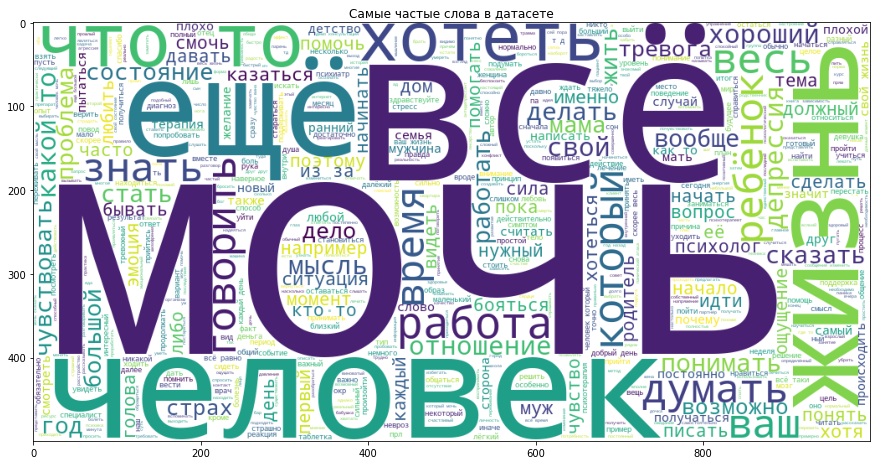

In [23]:
wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=RANDOM_STATE) # создание WordCloud объекта
wordcloud.generate(" ".join(dataset[DATA_COL])) # отправляем в WordCloud весь текст из датасета

plt.figure(figsize=(15,10)) # задание размера фигуры
plt.imshow(wordcloud) # отображение картинки
plt.title("Самые частые слова в датасете") # название фигуры
plt.show() # показ фигуры

## Векторизация (токенизация) данных

### a) Word-Piece keras токенизатор

Dataset.from_tensor_slices(dataset[DATA_COL]):
   - tensorflow.data.Dataset — это API TensorFlow для работы с данными. Он предоставляет утилиты для загрузки, препроцессинга и эффективного управления данными для обучения моделей.
   - from_tensor_slices — это метод класса `tf.data.Dataset`, который создает объект `Dataset` из данных, предоставленных в виде массивов (тогда как сами данные могут быть в различных форматах, таких как `numpy` массивы, списки, или как здесь - `pandas.Series`).
   - dataset[DATA_COL] передается в метод `from_tensor_slices`, чтобы создать Dataset, где каждой строке серии DataFrame соответствует один элемент в Dataset.

In [14]:
# vocab = compute_word_piece_vocabulary(data=Dataset.from_tensor_slices(dataset[DATA_COL]), vocabulary_size=MAX_WORDS_TOKENIZER, lowercase=True) # генерируем word_piece словарь
# # with open(f"{DATA_DIR}vocab_lem_sto_28.pkl", 'wb') as f:
# #     pickle.dump(vocab, f)
# # with open(f"{DATA_DIR}vocab.pkl", 'rb') as f:
# #     vocab = pickle.load(f)

# word2id = {} # словарь соответствия слова его id_шнику
# id2word = {} # словарь соответствия id_шника слову
# for id, word in enumerate(vocab): # идём по словам в словаре
#     word2id[word] = id # заполняем словарь соответствия слова его id_шнику
#     id2word[id] = word # заполняем словарь соответствия id_шника слову

# vocab_size = len(vocab) # число слов в корпусе
# docs_count = len(dataset) # число документов в корпусе

# print(f"Число уникальных токенов в корпусе: {vocab_size}.") # включая специальные токены
# list(word2id.items())[:10] # первые 10 элементов словаря конвертации слова в токен (id)

Число уникальных слов в корпусе: 12681.


[('[PAD]', 0),
 ('[CLS]', 1),
 ('[SEP]', 2),
 ('[UNK]', 3),
 ('[MASK]', 4),
 ('!', 5),
 ('#', 6),
 ('$', 7),
 ('%', 8),
 ('&', 9)]

In [15]:
# tokenizer = WordPieceTokenizer(vocabulary=vocab, sequence_length=MAX_SEQUENCE_LEN, lowercase=True, oov_token="[UNK]") # создаём объект токенизатора на основании сгенерированного словаря
# encoded_data = tokenizer.tokenize(dataset[DATA_COL]).numpy() # токенизируем документы и конвертируем в numpy array (они сразу имеют padding и truncation)
# print(f"Пример токенизации документа: {encoded_data[0]}.") # пример токенизации первого документа

Пример токенизации документа: [  128   298   151     5   916    21   430    17   246   216  2858    92
 10435  4135  1812  7574    15   118   355   235    17   185   233    16
   237   118   242  1839   170    11  3552   665  7269    15  3524  2585
   871    15   355    12    15   325   289   194  1839    15   355   233
    16   237    15   355   372   156   163   871   578  1522   226   531
    17   170   358   242   121   375   316    17   656   858 10847   151
    15   648   177   160    17   136    34   119   421    15    15  1624
  1208   182    23   151  3524  3594    17   314    15  1208  1711    11
    20    20    16    21].


In [16]:
# for token in encoded_data[0][:50]: # идём по токенам примера 0
#     print(f"{token} — {id2word[token]}") # выводим токен (id) и соответствующее ему слово

128 — весь
298 — добрый
151 — день
5 — !
916 — бар
21 — 2
430 — тип
17 — .
246 — начало
216 — часто
2858 — употреблять
92 — с
10435 — ##пи
4135 — ##рт
1812 — ##ной
7574 — напиток
15 — ,
118 — это
355 — помнить
235 — происходить
17 — .
185 — именно
233 — из
16 — -
237 — за
118 — это
242 — несколько
1839 — ругаться
170 — муж
11 — (
3552 — творить
665 — всякий
7269 — дичь
15 — ,
3524 — вплоть
2585 — звонок
871 — бывший
15 — ,
355 — помнить
12 — )
15 — ,
325 — последний
289 — сильно
194 — начать
1839 — ругаться
15 — ,
355 — помнить
233 — из
16 — -
237 — за


### b) Обычный keras токенизатор

In [24]:
tokenizer = Tokenizer(num_words=MAX_WORDS_TOKENIZER, filters='', lower=True, split=" ", char_level=False, oov_token='<OOV>') # создаём объект токенизатора, без ограничения числа токенов (num_words=None)
tokenizer.fit_on_texts(dataset[DATA_COL]) # обучаем токенизатор на текстах

In [25]:
if MAX_WORDS_TOKENIZER is None: # если нет ограничения на число слов
    word2id = tokenizer.word_index # словарь соответствия слова его id_шнику (все слова в датасете)
    id2word = tokenizer.index_word # словарь соответствия id_шника слову (все слова в датасете)
else: # если есть ограничение на число слов
    word2id = {item[0]: item[1] for item in tokenizer.word_index.items() if item[1] < MAX_WORDS_TOKENIZER} # словарь соответствия слова его id_шнику (с версии tensorflow 2.16 словарь сразу обрезан по MAX_WORDS_TOKENIZER)
    id2word = {item[0]: item[1] for item in tokenizer.index_word.items() if item[0] < MAX_WORDS_TOKENIZER} # словарь соответствия id_шника слову (не ограничены MAX_FEATURES)

id2word[0] = "<pad>" # добавление токена пропуска (<pad>) под индексом 0
word2id["<pad>"] = 0 # добавление токена пропуска (<pad>) под индексом 0

vocab_size = len(id2word) # число слов в корпусе
docs_count = len(dataset) # число документов в корпусе

print(f"Число уникальных токенов в корпусе: {vocab_size}.") # включая специальные токены
list(word2id.items())[:10] # первые 10 элементов словаря конвертации слова в токен (id)

Число уникальных токенов в корпусе: 20000.


[('<OOV>', 1),
 ('мочь', 2),
 ('всё', 3),
 ('свой', 4),
 ('человек', 5),
 ('который', 6),
 ('ваш', 7),
 ('жизнь', 8),
 ('ещё', 9),
 ('хотеть', 10)]

In [26]:
encoded_data = tokenizer.texts_to_sequences(dataset[DATA_COL]) # токенизируем документы
print(f"Пример токенизации документа: {encoded_data[0]}.") # пример токенизации первого документа

Пример токенизации документа: [12, 120, 19, 644, 148, 347, 118, 93, 2536, 16283, 5880, 233, 104, 59, 106, 113, 1633, 54, 3630, 539, 6783, 3019, 2027, 735, 233, 176, 153, 70, 1633, 233, 106, 233, 234, 36, 38, 735, 405, 1376, 98, 376, 54, 253, 113, 4, 241, 175, 455, 722, 8086, 19, 564, 63, 43, 20, 2, 288, 1253, 1016, 62, 417, 19, 3019, 3075, 194, 1016, 1352, 282, 2464, 19, 137, 572, 10, 3, 1561, 897, 472, 3860, 1462, 33, 16284, 5881, 12, 4, 8, 14, 74, 2072, 3631, 4, 111, 247, 3, 1561, 109, 37, 136, 23, 112, 501, 112, 4604, 1957, 366, 6, 183, 76, 49, 276, 42, 3253, 3310, 456, 211, 698, 36, 308, 965, 1424, 243, 12, 185].


Приведение последовательностей токенов к одной длине (размерности).

In [29]:
lengths = [] # список под длины документов в токенах
for doc in encoded_data: # идём по токенизированным документам
    lengths.append(len(doc)) # добавляем число токенов в документе в список

print(f"Максимальная длина документа в токенах: {max(lengths)}.")
print(f"Квантиль длины документа уровня 0.95: {np.quantile(lengths, q=0.95)}.")

Максимальная длина документа в токенах: 2723.
Квантиль длины документа уровня 0.95: 159.0.


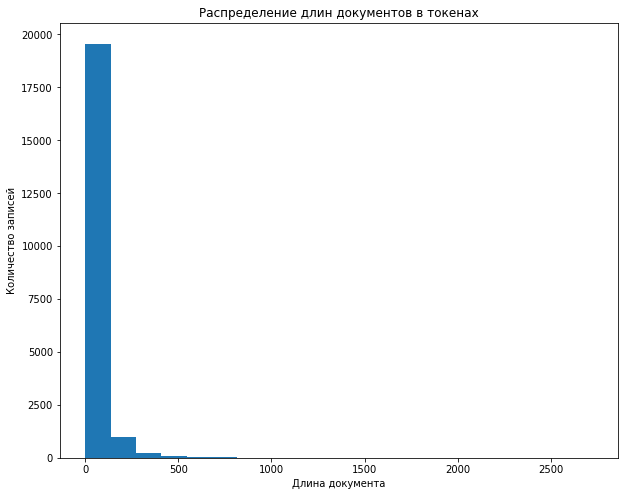

In [30]:
plt.figure(figsize=(10,8)) # задание размера фигуры
plt.hist(lengths, bins=20) # построение столбчатой диаграммы по данным
plt.title("Распределение длин документов в токенах") # название фигуры
plt.xlabel("Длина документа") # подпись по оси x
plt.ylabel("Количество записей") # подпись по оси y
plt.show() # показ фигуры

In [31]:
encoded_data = pad_sequences(encoded_data, maxlen=MAX_SEQUENCE_LEN, padding="post", truncating="post", value=0) # приводим вектора токенов к единой размерности MAX_SEQUENCE_LEN с помощью padding_а и truncating_а (заполняем значением value)

In [32]:
for token in encoded_data[0][:50]: # идём по токенам примера 0
    print(f"{token} — {id2word[token]}") # выводим токен (id) и соответствующее ему слово

12 — весь
120 — добрый
19 — день
644 — бар
148 — 2
347 — тип
118 — начало
93 — часто
2536 — употреблять
16283 — спиртной
5880 — напиток
233 — помнить
104 — происходить
59 — именно
106 — из-за
113 — несколько
1633 — ругаться
54 — муж
3630 — творить
539 — всякий
6783 — дичь
3019 — вплоть
2027 — звонок
735 — бывший
233 — помнить
176 — последний
153 — сильно
70 — начать
1633 — ругаться
233 — помнить
106 — из-за
233 — помнить
234 — лишь
36 — чувство
38 — страх
735 — бывший
405 — появляться
1376 — дверь
98 — наш
376 — квартира
54 — муж
253 — взять
113 — несколько
4 — свой
241 — вещь
175 — уйти
455 — домой
722 — возвращаться
8086 — седьмой
19 — день


## Train-test Split

In [33]:
data_X = pd.DataFrame(encoded_data, columns=[f"Токен {i+1}" for i in range(encoded_data.shape[1])]) # конвертируем в DataFrame

print(f"Финальная размерность токенизированных документов: сэмплов — {data_X.shape[0]}, токенов — {data_X.shape[1]}.")
data_X

Финальная размерность токенизированных документов: сэмплов — 20894, токенов — 159.


,Токен 1,Токен 2,Токен 3,Токен 4,Токен 5,Токен 6,Токен 7,Токен 8,Токен 9,Токен 10,...,Токен 150,Токен 151,Токен 152,Токен 153,Токен 154,Токен 155,Токен 156,Токен 157,Токен 158,Токен 159
0,12,120,19,644,148,347,118,93,2536,16283,...,0,0,0,0,0,0,0,0,0,0
1,1250,3495,23,631,5,4360,154,3,23,1262,...,0,0,0,0,0,0,0,0,0,0
2,23,1284,3960,926,127,112,254,204,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4489,1021,39,33,42,46,81,425,1665,1332,...,0,0,0,0,0,0,0,0,0,0
4,5,644,1502,620,1905,2115,827,2290,7,103,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20889,976,422,1502,316,513,549,6230,1256,3314,115,...,0,0,0,0,0,0,0,0,0,0
20890,549,183,3,76,76,273,271,2240,401,17,...,0,0,0,0,0,0,0,0,0,0
20891,1022,2129,243,845,5972,125,2783,108,8,17673,...,131,12759,5827,346,2,549,50,1179,7,41
20892,2856,162,5790,17,714,272,49,3321,5790,112,...,0,0,0,0,0,0,0,0,0,0


In [34]:
data_y = pd.get_dummies(dataset[TARGET_COL], dtype=DTYPE) # делаем One-hot encoding для таргетов
labels = data_y.columns # уникальные значения таргетов (колонки One-hot encodding таргетов)

print(f"Размерность таргетов: сэмплов — {data_y.shape[0]}, таргетов — {data_y.shape[1]}.")
data_y

Размерность таргетов: сэмплов — 20894, таргетов — 6.


,БАР,ДЕПРЕССИЯ,ОКР,ПРЛ,ТРЕВОЖНОЕ Р-ВО,ШИЗОФРЕНИЯ
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
20889,0.0,0.0,0.0,0.0,0.0,1.0
20890,0.0,0.0,0.0,0.0,0.0,1.0
20891,0.0,0.0,0.0,0.0,0.0,1.0
20892,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_y, shuffle=True)
# разбиваем датасет (data_X — данные, data_y — One-hot encoded таргеты) на обучающую и тестовую выборки в соотношении TEST_SIZE, при этом пропорция таргетов должна быть одинаковой (stratify=data_y) в обоих выборках и данные должны быть перемешаны (shuffle=True)

c:\Users\User\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\User\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\User\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Resampling

In [36]:
# if SAMPLES_PER_CLASS: # если число сэплов за класс задано
#     max_samples = SAMPLES_PER_CLASS # используем его как параметр для resample
# else: # иначе — выравниваем по самому представленному классу
#     max_samples = y_train.value_counts()[0] # число элементов в наиболее представленном классе

# # сначала получаем данные о распределении фич для каждого класса, чтобы потом провести их выравнивание (resampling)
# y_values = y_train.idxmax(axis=1) # обратно преобразовываем One-hot таргеты в один столбец (только для поиска распределения данных X)
# data_resampled = pd.DataFrame(columns=[X_train.columns].extend(labels)) # заготовка под DataFrame без дисбаланса классов (слолбцы — всё, что есть в data_X и data_y)
# for target_value in labels: # идём по уникальным таргетам
#     data_distribution = X_train[y_values == target_value] # записываем в data_distribution TF-IDF вектора, соответствующие рассматриваемому target_value
#     print(f"    В классе '{target_value}' было {len(data_distribution)} записей.")

#     data_distribution = resample(data_distribution, n_samples=max_samples, random_state=RANDOM_STATE) # добавляем (удаляем) записи к рассматриваемому таргету до n_samples по соответствующему распределению
#     print(f"    В классе '{target_value}' стало {len(data_distribution)} записей.")

#     data_for_label = pd.DataFrame(data_distribution) # создаём DataFrame из векторов, соответствующих рассматриваемому таргету
#     data_for_label[labels] = pd.DataFrame([y_train[y_values == target_value].iloc[0]], index=data_for_label.index) # добавляем колонки One-hot таргета в DataFrame (index=data_for_label.index — у всех строк будет значение рассматриваемого таргета) (.iloc[0] — берём первое значение One-hot вектора таргета, что совпало по инексу с его не One-hot версией)
#     data_resampled = pd.concat([data_resampled, data_for_label], ignore_index=True) # соединяем вместе все DataFrame_ы классов

# data_resampled = data_resampled.sample(frac=1) # случайным образом перемешиваем датасет

# y_train = data_resampled[labels] # запоминаем таргеты (One-hot)
# data_resampled.drop(labels, axis=1, inplace=True) # в data_resampled (DataFrame) оставляем только вектора фич
# X_train = data_resampled # возвращаем фичи к типу array (хоть можно было оставить и DataFrame)


# # очищаем память из под вспомогательных объектов
# del data_distribution
# del data_for_label
# del data_resampled
# print(f"Размерность после обработки: сэмплов — {X_train.shape[0]}, фич — {X_train.shape[1]}, таргетов — {y_train.shape[1]}.")

Получившиеся матрицы.

In [37]:
X_train

,Токен 1,Токен 2,Токен 3,Токен 4,Токен 5,Токен 6,Токен 7,Токен 8,Токен 9,Токен 10,...,Токен 150,Токен 151,Токен 152,Токен 153,Токен 154,Токен 155,Токен 156,Токен 157,Токен 158,Токен 159
13424,9,1034,2728,38,484,3303,1087,72,3856,1924,...,0,0,0,0,0,0,0,0,0,0
13278,120,19,3393,3969,45,62,19,10209,699,556,...,0,0,0,0,0,0,0,0,0,0
15983,115,986,389,855,1106,115,2128,436,23,287,...,0,0,0,0,0,0,0,0,0,0
2286,2928,7626,8,1278,1690,6353,6,107,15,0,...,0,0,0,0,0,0,0,0,0,0
17452,999,1028,999,17,272,1870,17,350,723,6082,...,145,762,31,56,444,462,233,3857,1308,2753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18826,1340,1600,249,342,69,941,9497,1941,3367,1,...,0,0,0,0,0,0,0,0,0,0
4095,79,23,14,802,705,742,14572,3437,950,1104,...,0,0,0,0,0,0,0,0,0,0
1231,56,73,5,273,74,439,6,56,2839,878,...,0,0,0,0,0,0,0,0,0,0
18951,3661,3064,1,26,66,32,408,31,38,1,...,0,0,0,0,0,0,0,0,0,0


In [38]:
y_train

,БАР,ДЕПРЕССИЯ,ОКР,ПРЛ,ТРЕВОЖНОЕ Р-ВО,ШИЗОФРЕНИЯ
13424,0.0,0.0,1.0,0.0,0.0,0.0
13278,0.0,0.0,1.0,0.0,0.0,0.0
15983,0.0,0.0,0.0,0.0,1.0,0.0
2286,0.0,1.0,0.0,0.0,0.0,0.0
17452,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
18826,0.0,0.0,0.0,0.0,1.0,0.0
4095,0.0,1.0,0.0,0.0,0.0,0.0
1231,0.0,1.0,0.0,0.0,0.0,0.0
18951,0.0,0.0,0.0,0.0,1.0,0.0


Распределение таргетов после resample.

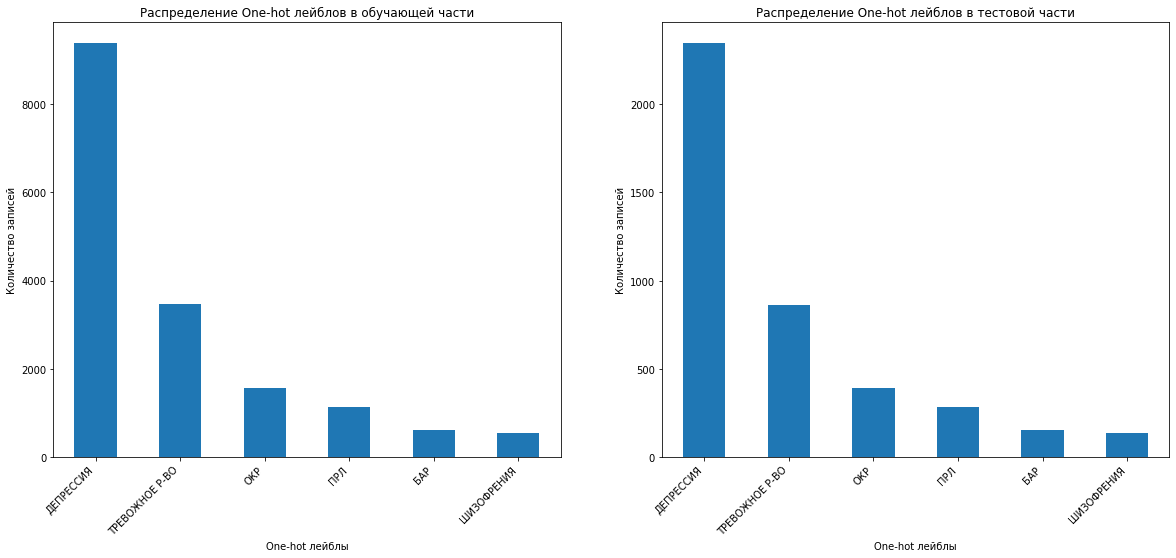

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

y_train.idxmax(axis=1).value_counts().plot.bar(ax=axes[0]) # построение столбчатой диаграммы по данным на оси ax (idxmax — чтобы преобразовать One-hot encoded данные обратно в таргеты)
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[0].set_title("Распределение One-hot лейблов в обучающей части") # название фигуры
axes[0].set_xlabel("One-hot лейблы") # подпись по оси OX
axes[0].set_ylabel("Количество записей") # подпись по оси OY

y_test.idxmax(axis=1).value_counts().plot.bar(ax=axes[1]) # построение столбчатой диаграммы по данным на оси ax (idxmax — чтобы преобразовать One-hot encoded данные обратно в таргеты)
axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[1].set_title("Распределение One-hot лейблов в тестовой части") # название фигуры
axes[1].set_xlabel("One-hot лейблы") # подпись по оси OX
axes[1].set_ylabel("Количество записей") # подпись по оси OY

plt.show() # показ фигуры

## Эмбеддинги

Для получения векторов-эмбеддингов воспользуемся [***Navec***](https://github.com/natasha/navec?tab=readme-ov-file), так как он компактный (легко умещается в память оперативную/физическую), хоть и имеет огромный словарь, и заточен под работу с русским языком. Словарь Navec содержит 500000 слов, представленных в виде векторов размерности 300.

In [40]:
navec = Navec.load(f"{EMBEDDING_DIR}navec_hudlit_v1_12B_500K_300d_100q.tar") # загружаем вектора
# navec_hudlit_v1_12B_500K_300d_100q.tar
#                  |    |    |    |
#                  |    |    |     ---- 100 dimentions after quantization
#                  |    |     --------- original vectors have 300 dimentions
#                  |     -------------- vocab size is 500 000 words + 2 for <unk>, <pad>
#                   ------------------- dataset of 12 billion tokens was used

In [41]:
navec.get("россия") # пример работы Navec (возвращает np.array типа float32)

array([ 0.22543699, -0.39721358,  0.6805563 ,  0.21706595, -0.19716908,
       -0.20722607, -0.07350219,  0.13129961, -0.17141329,  0.09088685,
        0.21599719, -0.09282316,  0.00766279, -0.11043157, -0.07346303,
        0.42286018, -0.26629096,  0.31371886, -0.08937341,  0.09485467,
       -0.04480258, -0.44643393, -0.3061798 , -0.2882515 ,  0.5377174 ,
        0.36234093,  0.0030303 ,  0.23453966, -0.28672412, -0.20668298,
       -0.19193137,  0.04902396,  0.8125157 ,  0.5318507 , -0.6188356 ,
       -0.04572238, -0.02173791, -0.66719943, -0.7230108 , -0.2762196 ,
       -0.23562106,  0.5413357 , -0.05294172,  0.6201654 , -0.8374897 ,
       -0.36382714,  0.4649254 , -0.13510832,  0.09727751, -0.10602053,
        0.37899598, -0.36541265, -0.20060915,  0.10681065, -0.5519943 ,
       -0.13753682, -0.01502502,  0.09474958, -0.05980838, -0.02857767,
       -0.55855787, -0.04823827, -0.3578416 ,  0.88438463,  0.32023084,
       -0.25467572,  0.22748815, -0.6873215 , -0.04857488, -0.74

In [42]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM)) # создаём матрицу из нулей под эмбеддинги слов (+1 — для вектора паддинга, что будет идти под индексом 0)

skipped_words = [] # список под слова без вектора
for i in range(1, vocab_size): # идём по числу слов (токенов), начиная с 1, так как 0 под padding и до vocab_size не включительно (чтобы уместить все слова)
    word = id2word[i] # слово, что идёт под номером i в токенизаторе
    if navec.get(word) is not None: # если у рассматриваемого слова есть вектор в Navec (иначе вернёт None)
        embedding_matrix[i] = navec.get(word) # записываем i-ый вектор в матрицу эмбеддингов
    else: # если слова нет в Navec
        skipped_words.append(word) # добавляем слово в список пропущенных

print(f"Пропущенно {len(skipped_words)} слов из {vocab_size}.")

Пропущенно 4301 слов из 20000.


# Работа с моделью

In [43]:
input_size = X_train.shape[1] # размер входного вектора (для одного сэмпла, в данном случае совпадает с MAX_SEQUENCE_LEN)
target_size = y_train.shape[1] # размер выходного вектора (число таргетов)

In [44]:
layer_input = Input(shape=(input_size,), dtype=np.int32, name='input_tokens') # первый входной слой модели, получает вектор размера (BATCH_SIZE, число слов или токенов в документе)

# layer_embedding = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, name='embedding')(layer_input) # слой эмбеддинга (на вход — encoder_input размера словаря input_dim, выход размерности (BATCH_SIZE, число токенов в документе, размерность вектора-эмбеддинга))
layer_embedding = TokenAndPositionEmbedding(vocabulary_size=vocab_size, sequence_length=MAX_SEQUENCE_LEN, embedding_dim=EMBEDDING_DIM, mask_zero=True, name='embedding')(layer_input) # слой эмбеддинга токенов и их позиций (vocabulary_size - размер словаря, sequence_length - количество токенов в последовательности, embedding_dim - размер вектора эмбеддинга, mask_zero - флаг, что значения 0 это padding и его нужно маскировать)

layer_lstm = LSTM(units=64, return_sequences=False, return_state=False, name='lstm')(layer_embedding) # слой LSTM, return_state — возвращать ли помимо выхода слоя, также свой hidden_state и вектор context_а; return_sequences — возвращать лишь последний выход или выходы для всй входной последовательности (False - возвращать один вектор размерности units после обработки всей пришедшей последовательности)
layer_linear_1 = Dense(units=128, activation="relu", name='dense_1')(layer_lstm) # полносвязный (линейный) слой, выход которго имеет размерность (BATCH_SIZE, units)
layer_dropout_1 = Dropout(rate=0.1, name='dropout_1')(layer_linear_1) # слой dropout, зануляющий некоторые входы с вероятностью rate для борьбы с переобучением
layer_linear_2 = Dense(units=256, activation="relu", name='dense_2')(layer_dropout_1) # полносвязный (линейный) слой, выход которго имеет размерность (BATCH_SIZE, units)
layer_dropout_2 = Dropout(rate=0.1, name='dropout')(layer_linear_2) # слой dropout, зануляющий некоторые входы с вероятностью rate для борьбы с переобучением
layer_output = Dense(units=target_size, activation="softmax", name='labels_prob')(layer_dropout_2) # полносвязный (линейный) слой, activation="softmax" — для получения вероятностей классов, выход будет иметь размерность (BATCH_SIZE, units)

model = Model(inputs=layer_input, outputs=layer_output) # объединение слоёв в модель
model.summary() # вывод данных о модели


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_tokens (InputLayer)   [(None, 159)]             0         
                                                                 
 embedding (TokenAndPositio  (None, 159, 300)          6047700   
 nEmbedding)                                                     
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                            

In [45]:
model.layers[1].set_weights([embedding_matrix, model.layers[1].get_weights()[1]]) # устанавливаем вектора эмбеддингов (только для слов, позиции остаются как были - model.layers[1].get_weights()[1])
# model.layers[1].set_weights([embedding_matrix]) # устанавливаем вектора эмбеддингов
# model.layers[1].trainable = False # ставим флаг, что слой не будет обучаться

## Оптимизатор обучения модели

In [46]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE) # оптимизатор обучения модели

## Callback функции

In [47]:
def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops learning when the
    validation (testing) accuracy has not improved over the last N epochs.
    """
    early_stopping = EarlyStopping(monitor="val_f1_score", mode="max", patience=EPOCHS_PATIENCE) # callback ранней остановки обучения
    # monitor — по какой метрике судить, нужно ли прекращать обучение, например - val_loss или loss
    # mode — метрика должна увеличиваться (max) или уменьшаться (min)
    # patience — сколько должно пройти эпох без улучшения отслеживаемой метрики чтобы прекратить обучение
    return early_stopping


def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - stores only those weights of the neural network that generate the highest accuracy during testing
    - saves to the 'checkpoints_best_only' directory inside the current working directory
    - generates a file named '{MODELS_DIR}best_model.keras'
    """
    checkpoint_best = ModelCheckpoint(filepath=f"{MODELS_DIR}best_model.keras", save_best_only=True, save_weights_only=False, monitor="val_f1_score", mode="max") # callback сохранения чекпоинтов модели
    # filepath — путь до файла, куда сохранять (можно с указанием эпохи...)
    # save_best_only — сохранять только если результат (отслеживаемая метрика) улучшилась
    # save_weights_only — сохранять ли только веса
    # monitor — по какой метрике судить, стала ли модель лучше/хуже
    # mode — метрика должна увеличиваться (max) или уменьшаться (min)
    return checkpoint_best

## Сборка модели с обучением

In [48]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', keras.metrics.F1Score(average="macro")]) # компилирование модели с указанием оптимизатора, функции потерь и дополнительных метрик
# Binary cross entropy is calculated on top of sigmoid outputs, whereas Categorical cross-entropy is calculated over softmax activation outputs.

In [49]:
callback_checkpoint = get_checkpoint_best_only() # callback сохранения чекпоинтов
callback_stopping = get_early_stopping() # callback ранней остановки обучения

callbacks = [callback_checkpoint, callback_stopping] # список callback_ов

In [50]:
time_start = time.time() # замеряем время начала обучения

history = model.fit(x=X_train, y=y_train, validation_data=[X_test, y_test], validation_split=0, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1) # запускаем обучение модели (результатом которого будет история изменения метрик)
# x — вход модели
# y — таргеты
# epochs — число эпох обучения
# batch_size — размер батча
# validation_data — тестовые данные
# validation_split — если validation_data=None, то validation_split определяет, какой процент данных будет использован для валидации (на нём не будет обучения), например 0.2
# callbacks — список callback функций
# verbose — на сколько подробно выводить информацию об обучении (1 - на каждой эпохе)

print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд.")

Epoch 1/50


335/335 [==============================] - 87s 237ms/step - loss: 1.3021 - accuracy: 0.5642 - f1_score: 0.1430 - val_loss: 1.1971 - val_accuracy: 0.5767 - val_f1_score: 0.2012
Epoch 2/50
335/335 [==============================] - 86s 255ms/step - loss: 1.0869 - accuracy: 0.6417 - f1_score: 0.2235 - val_loss: 1.0673 - val_accuracy: 0.6396 - val_f1_score: 0.2245
Epoch 3/50
335/335 [==============================] - 85s 254ms/step - loss: 0.9736 - accuracy: 0.6705 - f1_score: 0.2649 - val_loss: 0.9839 - val_accuracy: 0.6631 - val_f1_score: 0.2897
Epoch 4/50
335/335 [==============================] - 97s 290ms/step - loss: 0.8763 - accuracy: 0.7014 - f1_score: 0.3543 - val_loss: 0.9345 - val_accuracy: 0.6858 - val_f1_score: 0.3599
Epoch 5/50
335/335 [==============================] - 81s 242ms/step - loss: 0.7863 - accuracy: 0.7358 - f1_score: 0.4390 - val_loss: 0.8979 - val_accuracy: 0.6927 - val_f1_score: 0.4314
Epoch 6/50
335/335 [==============================] - 83s 248ms

In [ ]:
model.save(f"{MODELS_DIR}final_model.keras") # сохранение модели

# Оценка качества модели

## Loss & Accuracy & F-score

In [51]:
history = history.history # словарь с историей обучения
print(history.keys()) # ключи в словаре истории

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


In [52]:
epochs = range(1, len(history["loss"]) + 1) # число эпох обучения (сколько было сохранено значений loss)
loss_train = history["loss"] # значение loss при обучении
loss_test = history["val_loss"] # значение loss при валидации
accuracy_train = history["accuracy"] # значение accuracy при обучении
accuracy_test = history["val_accuracy"] # значение accuracy при валидации
f_score_train = history["f1_score"] # значение F-score при обучении
f_score_test = history["val_f1_score"] # значение F-score при обучении

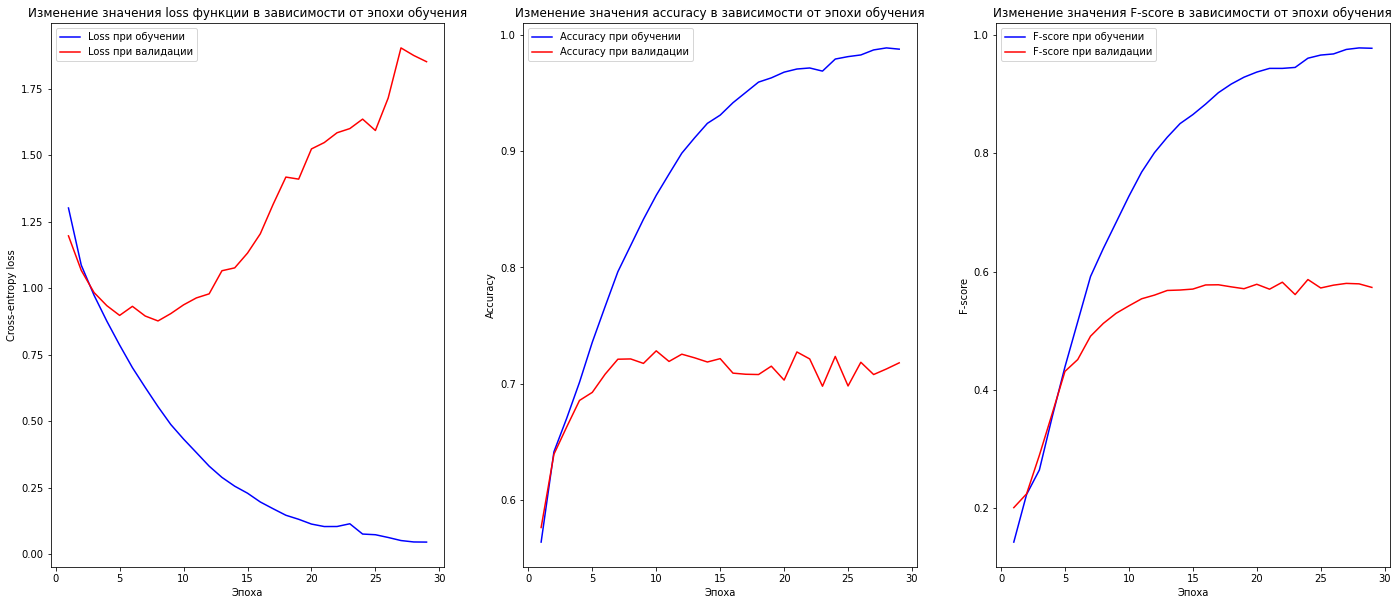

In [53]:
fig, axes = plt.subplots(ncols=3, figsize=(24,10)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

axes[0].plot(epochs, loss_train, color="b", label="Loss при обучении") # построение графика
axes[0].plot(epochs, loss_test, color="r", label="Loss при валидации") # построение графика
# axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[0].set_title("Изменение значения loss функции в зависимости от эпохи обучения") # название фигуры
axes[0].set_xlabel("Эпоха") # подпись по оси OX
axes[0].set_ylabel("Cross-entropy loss") # подпись по оси OY
axes[0].legend() # отображение подписей графиков

axes[1].plot(epochs, accuracy_train, color="b", label="Accuracy при обучении") # построение графика
axes[1].plot(epochs, accuracy_test, color="r", label="Accuracy при валидации") # построение графика
# axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[1].set_title("Изменение значения accuracy в зависимости от эпохи обучения") # название фигуры
axes[1].set_xlabel("Эпоха") # подпись по оси OX
axes[1].set_ylabel("Accuracy") # подпись по оси OY
axes[1].legend() # отображение подписей графиков

axes[2].plot(epochs, f_score_train, color="b", label="F-score при обучении") # построение графика
axes[2].plot(epochs, f_score_test, color="r", label="F-score при валидации") # построение графика
# axes[2].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[2].set_title("Изменение значения F-score в зависимости от эпохи обучения") # название фигуры
axes[2].set_xlabel("Эпоха") # подпись по оси OX
axes[2].set_ylabel("F-score") # подпись по оси OY
axes[2].legend() # отображение подписей графиков

plt.show() # показ фигуры

## F-score

In [54]:
model = keras.models.load_model(f"{MODELS_DIR}best_model.keras") # загружаем сохранённую модель
y_pred = model.predict(X_test) # делаем предсказание на тестовой выборке с помощью обученной модели
y_pred = np.argmax(y_pred, axis=1) # берём индекс (номер) самого вероятного класса в предсказаниях
y_true = np.argmax(y_test, axis=1) # берём индекс (номер) самого вероятного класса в правильных ответах

print(classification_report(y_true, y_pred, zero_division=0, target_names=labels)) # выводим основные метрики, такие как precision, recall, f1-score, accuracy (zero_division=0 — деление на ноль заменять нулём)

131/131 [==============================] - 7s 39ms/step
                precision    recall  f1-score   support

           БАР       0.37      0.34      0.36       154
     ДЕПРЕССИЯ       0.79      0.84      0.82      2345
           ОКР       0.56      0.49      0.53       394
           ПРЛ       0.69      0.70      0.69       286
ТРЕВОЖНОЕ Р-ВО       0.67      0.63      0.65       865
    ШИЗОФРЕНИЯ       0.55      0.41      0.47       135

      accuracy                           0.72      4179
     macro avg       0.61      0.57      0.59      4179
  weighted avg       0.72      0.72      0.72      4179



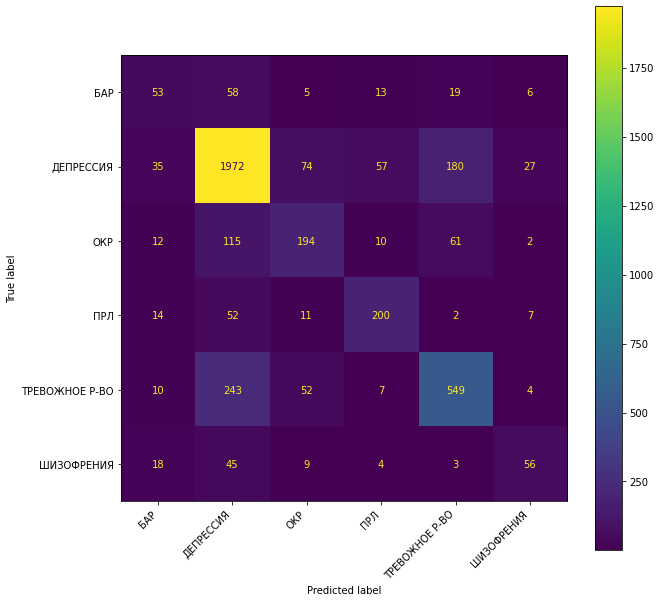

In [55]:
fig, ax = plt.subplots(figsize=(10,10)) # создание фигуры
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels).plot(ax=ax) # строим confusion matrix (стоит обратить внимание на display_labels, они могут не совпасть...)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
plt.show() # показ фигуры